In [1]:
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400.7 MB 4.5 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [2]:
import pandas as pd
import numpy as np

In [3]:
df=pd.read_excel("amazonLabelled.xlsx")

In [4]:
import en_core_web_lg
nlp=en_core_web_lg.load()

In [5]:
df = df[['Feedback','Sentiment']]
df.head()

,Feedback,Sentiment
0,"Good case, Excellent value.",Positive
1,Great for the jawbone.,Positive
2,Tied to charger for conversations lasting more...,Negative
3,The mic is great.,Positive
4,I have to jiggle the plug to get it to line up...,Negative


In [6]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
df['Sentiment'] = lb.fit_transform(df['Sentiment'])
df.head()

,Feedback,Sentiment
0,"Good case, Excellent value.",1
1,Great for the jawbone.,1
2,Tied to charger for conversations lasting more...,0
3,The mic is great.,1
4,I have to jiggle the plug to get it to line up...,0


In [7]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
wordnet = WordNetLemmatizer()
Feedback = []
x=df['Feedback']
for i in range (len(x)):
    feedback = re.sub("[^a-zA-Z]"," ",x[i])
    feedback = feedback.lower()
    feedback = feedback.split()
    feedback = [wordnet.lemmatize(word) for word in feedback if word not in set(stopwords.words("english"))]
    feedback = " ".join(feedback)
    Feedback.append(feedback)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [9]:
dt=pd.DataFrame(Feedback,columns=['feedback'])
del df["Feedback"]
new_df=dt.join(df, how='outer')
new_df

,feedback,Sentiment
0,good case excellent value,1
1,great jawbone,1
2,tied charger conversation lasting minute major...,0
3,mic great,1
4,jiggle plug get line right get decent volume,0
...,...,...
994,screen get smudged easily touch ear face,0
995,piece junk lose call phone,0
996,item match picture,0
997,thing disappoint infra red port irda,0


Word2vec conversion of the feedback


In [12]:
def get_vec(x):
  doc=nlp(x)
  vec=doc.vector
  return vec
new_df['vec']=new_df['feedback'].apply(lambda x:get_vec(x))  
new_df

,feedback,Sentiment,vec
0,good case excellent value,1,"[-0.27085474, 0.560745, -0.16895999, -0.057802..."
1,great jawbone,1,"[0.081682, 0.219695, -0.0226235, 0.272819, 0.0..."
2,tied charger conversation lasting minute major...,0,"[-0.09076928, 0.23803315, -0.0056542903, 0.119..."
3,mic great,1,"[-0.15999301, 0.55948997, 0.1326095, 0.271369,..."
4,jiggle plug get line right get decent volume,0,"[-0.04867725, 0.16868088, -0.07478875, 0.10400..."
...,...,...,...
994,screen get smudged easily touch ear face,0,"[0.07868713, -0.10389529, -0.263557, 0.1918769..."
995,piece junk lose call phone,0,"[-0.259266, 0.3243048, -0.1348128, 0.29401797,..."
996,item match picture,0,"[-0.12885533, 0.10869058, -0.018869663, 0.0825..."
997,thing disappoint infra red port irda,0,"[0.12522517, -0.18005617, -0.0486495, 0.041019..."


In [13]:
X=new_df['vec'].to_numpy()
X=X.reshape(-1,1)
X=np.concatenate(np.concatenate(X,axis=0),axis=0).reshape(-1,300)

In [14]:
X.shape

(999, 300)

In [15]:
y=new_df['Sentiment']

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2,stratify=y)

In [19]:
from sklearn.ensemble import RandomForestClassifier

model_RFC = RandomForestClassifier(random_state=6)
model_RFC.fit(X_train,y_train)

RandomForestClassifier(random_state=6)

In [20]:
acc_Randomforest=model_RFC.score(X_test,y_test)
acc_Randomforest

0.785

In [21]:
y_pred1= model_RFC.predict(X_test)


In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred1)

array([[81, 19],
       [24, 76]])

In [23]:
from sklearn.metrics import classification_report
classification_report(y_test,y_pred1)

'              precision    recall  f1-score   support\n\n           0       0.77      0.81      0.79       100\n           1       0.80      0.76      0.78       100\n\n    accuracy                           0.79       200\n   macro avg       0.79      0.79      0.78       200\nweighted avg       0.79      0.79      0.78       200\n'

In [24]:
from sklearn.linear_model import LogisticRegression
model_LR= LogisticRegression(random_state=6)
model_LR.fit(X_train,y_train)

LogisticRegression(random_state=6)

In [25]:
acc_log=model_LR.score(X_test,y_test)
acc_log

0.82

In [26]:
y_pred2= model_RFC.predict(X_test)

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred2)

array([[81, 19],
       [24, 76]])

In [28]:
from sklearn.metrics import classification_report
classification_report(y_test,y_pred2)

'              precision    recall  f1-score   support\n\n           0       0.77      0.81      0.79       100\n           1       0.80      0.76      0.78       100\n\n    accuracy                           0.79       200\n   macro avg       0.79      0.79      0.78       200\nweighted avg       0.79      0.79      0.78       200\n'

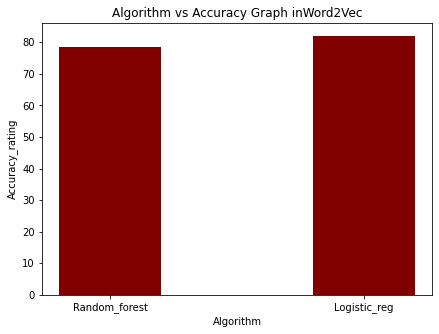

In [29]:
import matplotlib.pyplot as plt
 
  
# creating the dataset
data = {'Random_forest':acc_Randomforest*100, 'Logistic_reg':acc_log*100}
Algorithm = list(data.keys())
Accuracy = list(data.values())
fig = plt.figure(figsize = (7, 5))

plt.bar(Algorithm, Accuracy, color ='maroon',
        width = 0.4)
 
plt.xlabel("Algorithm")
plt.ylabel("Accuracy_rating")
plt.title("Algorithm vs Accuracy Graph inWord2Vec")
plt.show()